# Predictability Study

We are interested in predicting k, which is defined as the number of prefetches issued before a demand request. A sequence of k values is on a per cacheline basis.

### Predictability Metrics

**k distribution**: The distribution of all values of k per benchmark

**Sequiter Study**: Using the compression tool Sequiter to find patterns in the distribution of k on a per cacheline basis

**Uniqueness Study**: The distribution of the percent of unique values of k on a per cacheline basis

In [1]:
import sys, re
import matplotlib as mpl
import numpy as np
import os
import subprocess
import copy
mpl.rcParams['font.size'] = 14
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import argparse

NROWS=5
NCOLS=5

In [2]:
def parse_k_lists(trace):
    k_distr = []
    for line in open(trace, 'r'):
        if (re.match("cacheline:", line)):
            split = re.split(',| ', line.rstrip())
            split = [i.strip() for i in split if i.strip()]
            if (len(split) > 3):
                k_list = list(map(int, split[3:]))
                k_distr.extend(k_list)
                
    return k_distr

def get_k_list_compression(trace):
    k_compression = []
    for line in open(trace, 'r'):
        if (re.match("cacheline:", line)):
            split = re.split(',| ', line.rstrip())
            split = [i.strip() for i in split if i.strip()]
            if (len(split) > 9):
                k_list = split[3:]
                k_str = ""
                for k in k_list:
                    k_str += str(k)
                output = subprocess.check_output(f'echo -n {k_str} | ../sequitur/c++/sequitur -p', shell=True, stderr=subprocess.STDOUT)
                output_str = str(output)
                output_split = re.split('->', output_str)
                k_compression.append(len(output_split) - 1)
                if (len(k_compression) > 200):
                    break
    return k_compression

def get_k_list_unique(trace):
    k_unique_distr = []
    for line in open(trace, 'r'):
        if (re.match("cacheline:", line)):
            split = re.split(',| ', line.rstrip())
            split = [i.strip() for i in split if i.strip()]
            if (len(split) > 9):
                k_list = k_list = list(map(int, split[3:]))
                unique_k_list = set(k_list)
                k_unique_distr.append(len(unique_k_list))
    return k_unique_distr

In [3]:
def graph_k_distr(experiment_trace_files, traces):
    fig = plt.figure(figsize=(30, 30))
    spec = gridspec.GridSpec(nrows = NROWS, ncols = NCOLS, wspace = 0.2, hspace = 0.4)
    axs = []
    i = 0
    
    for r in range(NROWS):
        for c in range(NCOLS):
            ax = fig.add_subplot(spec[r, c])
            ax.set_ylabel('Frequency')
            ax.set_xlabel('k')
            if (i < len(traces)):
                ax.set_title(f'{traces[i]} k distribution')
            axs.append(ax)
            i += 1

    i = 0
    for trace in experiment_trace_files:
        k_distr = parse_k_lists(trace)
        bins = 10
        if (len(k_distr) != 0):
            bins = max(k_distr) - min(k_distr)
            if (bins == 0):
                bins = 10
        if (i < len(traces)):
            axs[i].hist(k_distr, bins=bins, rwidth=0.8)
        i += 1

In [4]:
def graph_k_compression(experiment_trace_files, traces):
    fig = plt.figure(figsize=(30, 30))
    spec = gridspec.GridSpec(nrows = NROWS, ncols = NCOLS, wspace = 0.2, hspace = 0.4)
    axs = []
    
    i = 0
    for r in range(NROWS):
        for c in range(NCOLS):
            ax = fig.add_subplot(spec[r, c])
            ax.set_ylabel('Frequency')
            ax.set_xlabel('compressability factor')
            if (i < len(traces)):
                ax.set_title(f'{traces[i]} k compressability')
            axs.append(ax)
        i += 1
    i = 0
    for trace in experiment_trace_files:
        k_compression = get_k_list_compression(trace)
        bins = 10
        if (len(k_compression) != 0):
            bins = max(k_compression) - min(k_compression)
            if (bins == 0):
                bins = 10
        if (i < len(traces)):
            axs[i].hist(k_compression, bins=bins, rwidth=0.8)
        i += 1

In [5]:
def graph_k_unique(experiment_trace_files, traces):
    fig = plt.figure(figsize=(30, 30))
    spec = gridspec.GridSpec(nrows = NROWS, ncols = NCOLS, wspace = 0.2, hspace = 0.4)
    axs = []
    
    i = 0
    for r in range(NROWS):
        for c in range(NCOLS):
            ax = fig.add_subplot(spec[r, c])
            ax.set_ylabel('Frequency')
            ax.set_xlabel('Percent Unique')
            if (i < len(traces)):
                ax.set_title(f'{traces[i]} k percent unique')
            axs.append(ax)
            i += 1
    i = 0
    for trace in experiment_trace_files:
        k_unique = get_k_list_unique(trace)
        bins = 20
        if (i < len(traces)):
            axs[i].hist(k_unique, bins=bins, rwidth=0.8)
        i += 1

## K Distribution Study

The following graphs show measures of predictability of k for each benchmark. The measures are
1. Distribution of k
2. Compressability of k
3. Percent Unique Values in k sequences

### Harmony with Best Offset Prefetcher

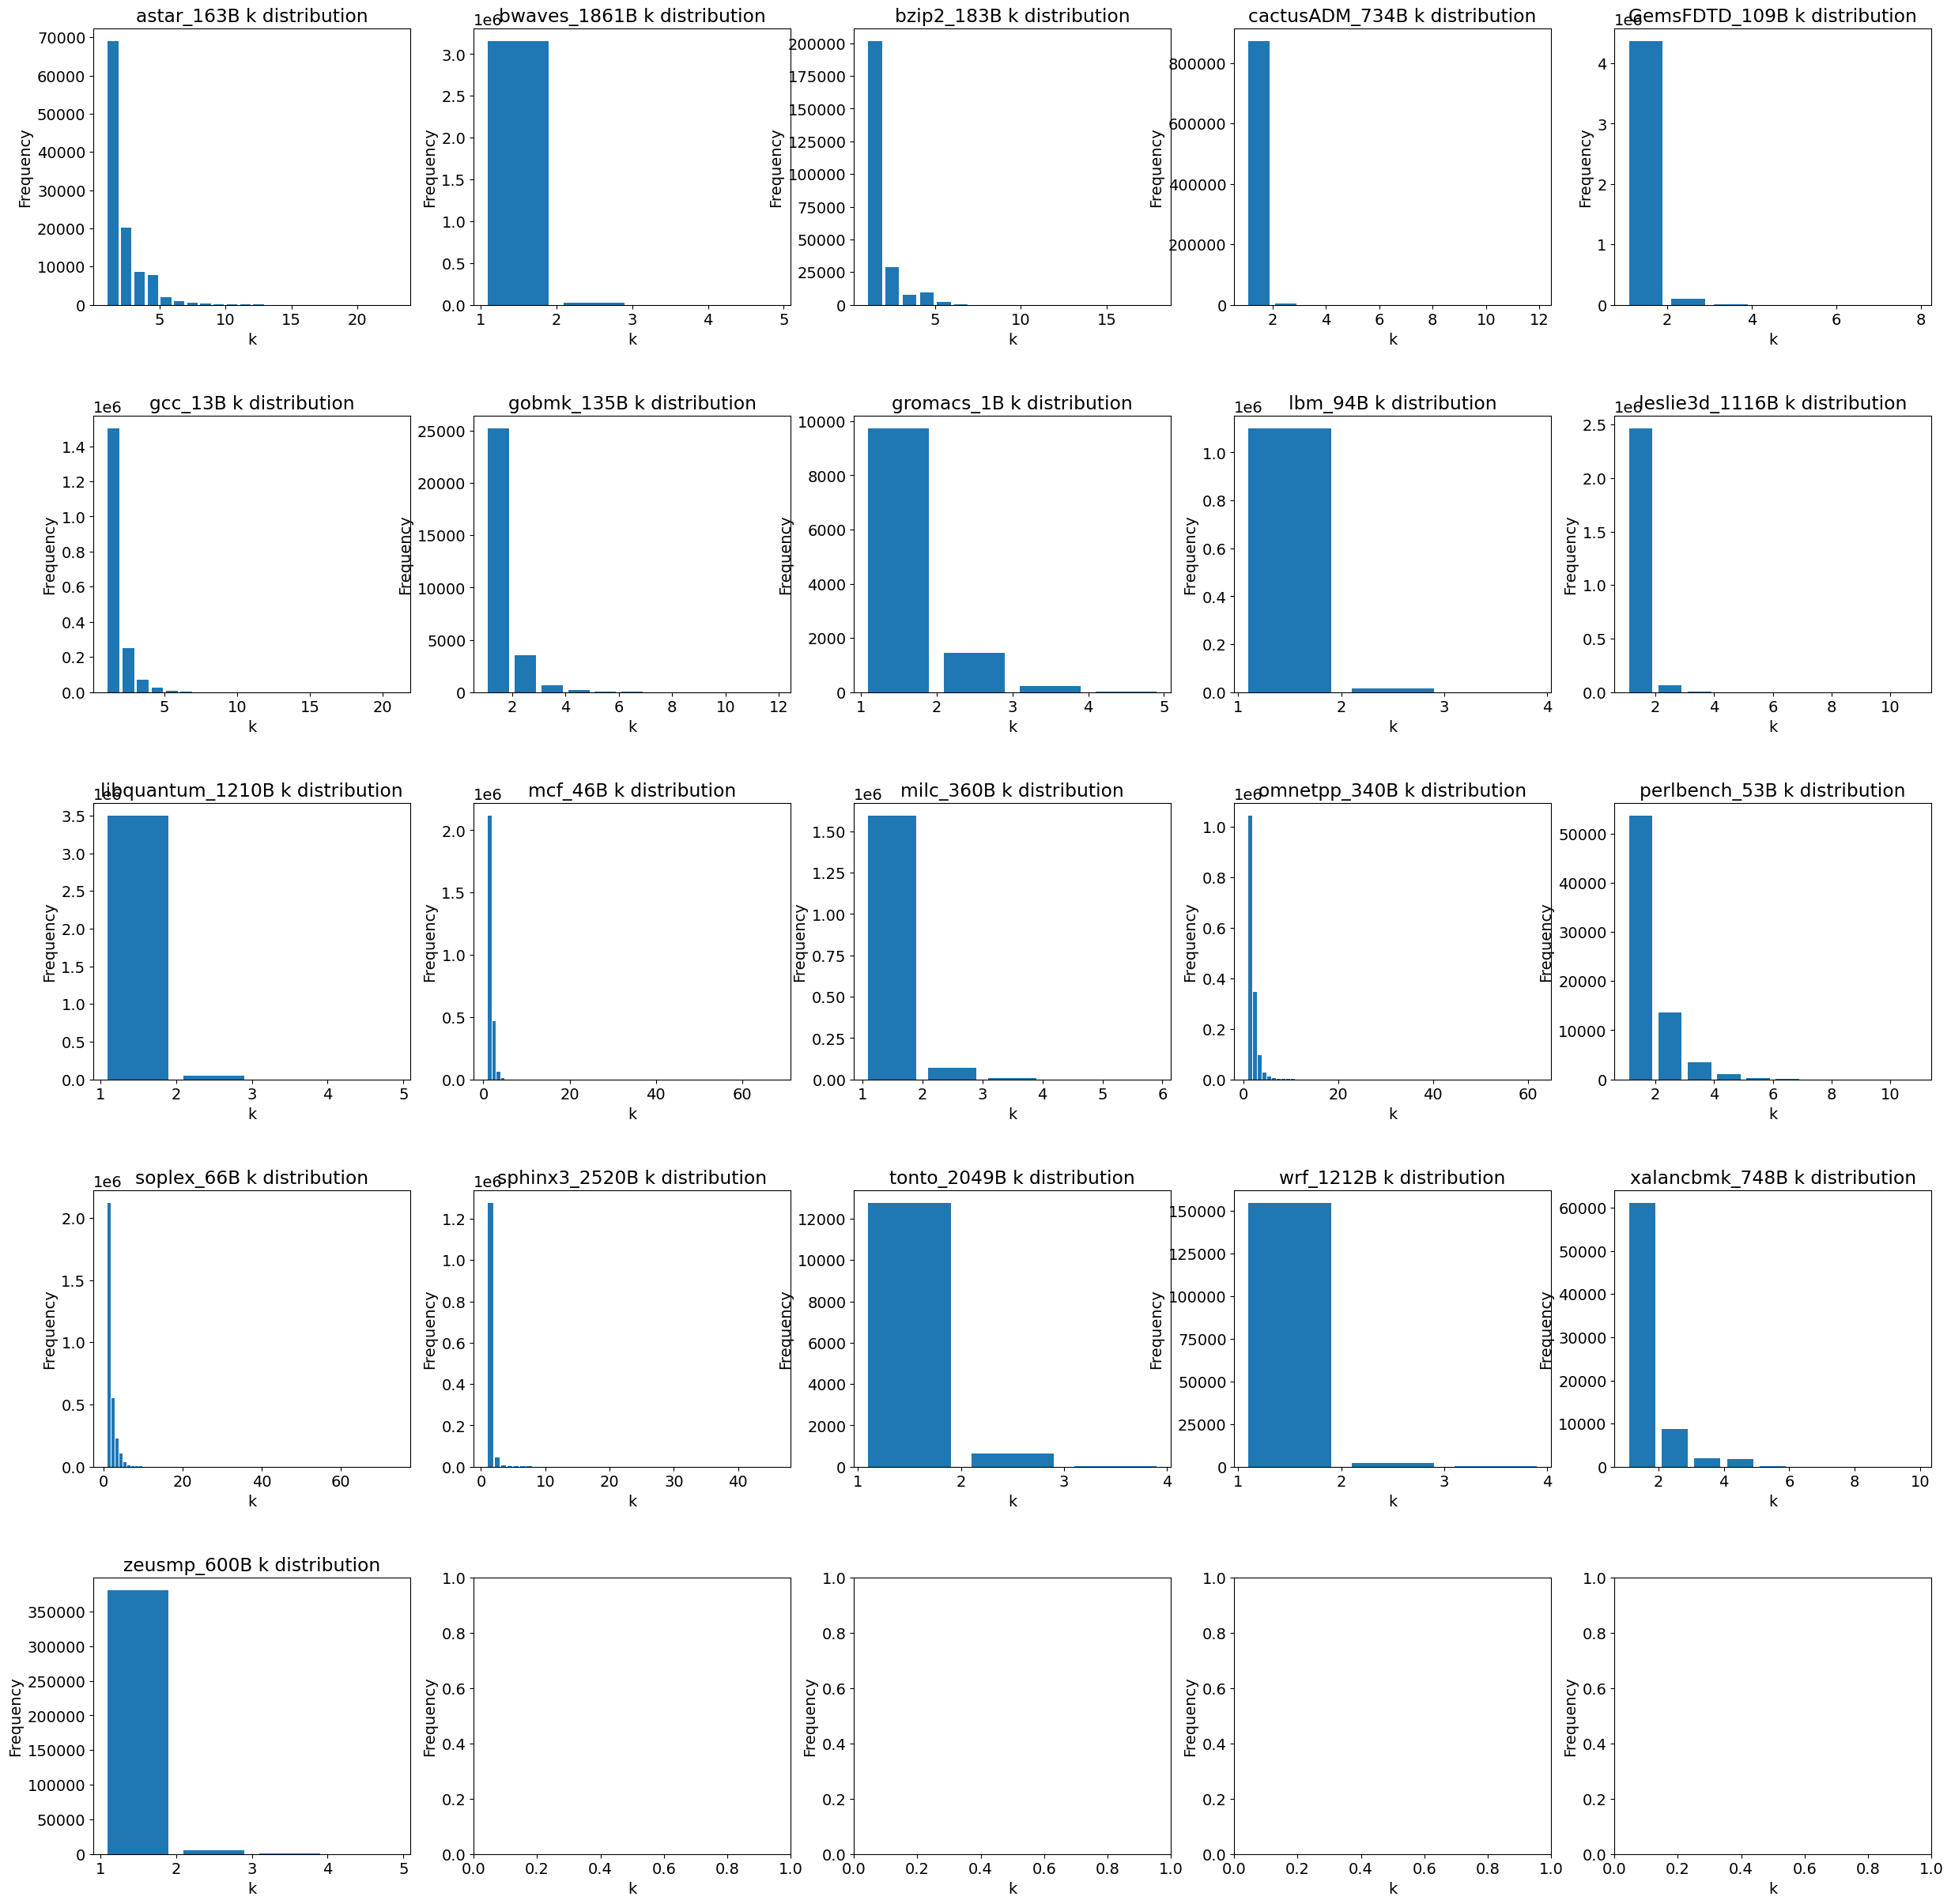

In [7]:
# Harmony with Best Offset Prefetch Interval Use
# get experiment trace files
experiment = 'experiment_tracer_hawkeye_final_dyn_bo_k_list'
trace_list = open('../sim_list/traces.txt', 'r')
experiment_trace_files = []
traces = []

for trace in trace_list:
    trace = trace[:-1]
    traces.append(trace)
    experiment_trace = '../current_output/'+experiment+'/'+trace+'.txt'
    experiment_trace_files.append(experiment_trace)

graph_k_distr(experiment_trace_files, traces)
plt.show()

### K Compressability Graph

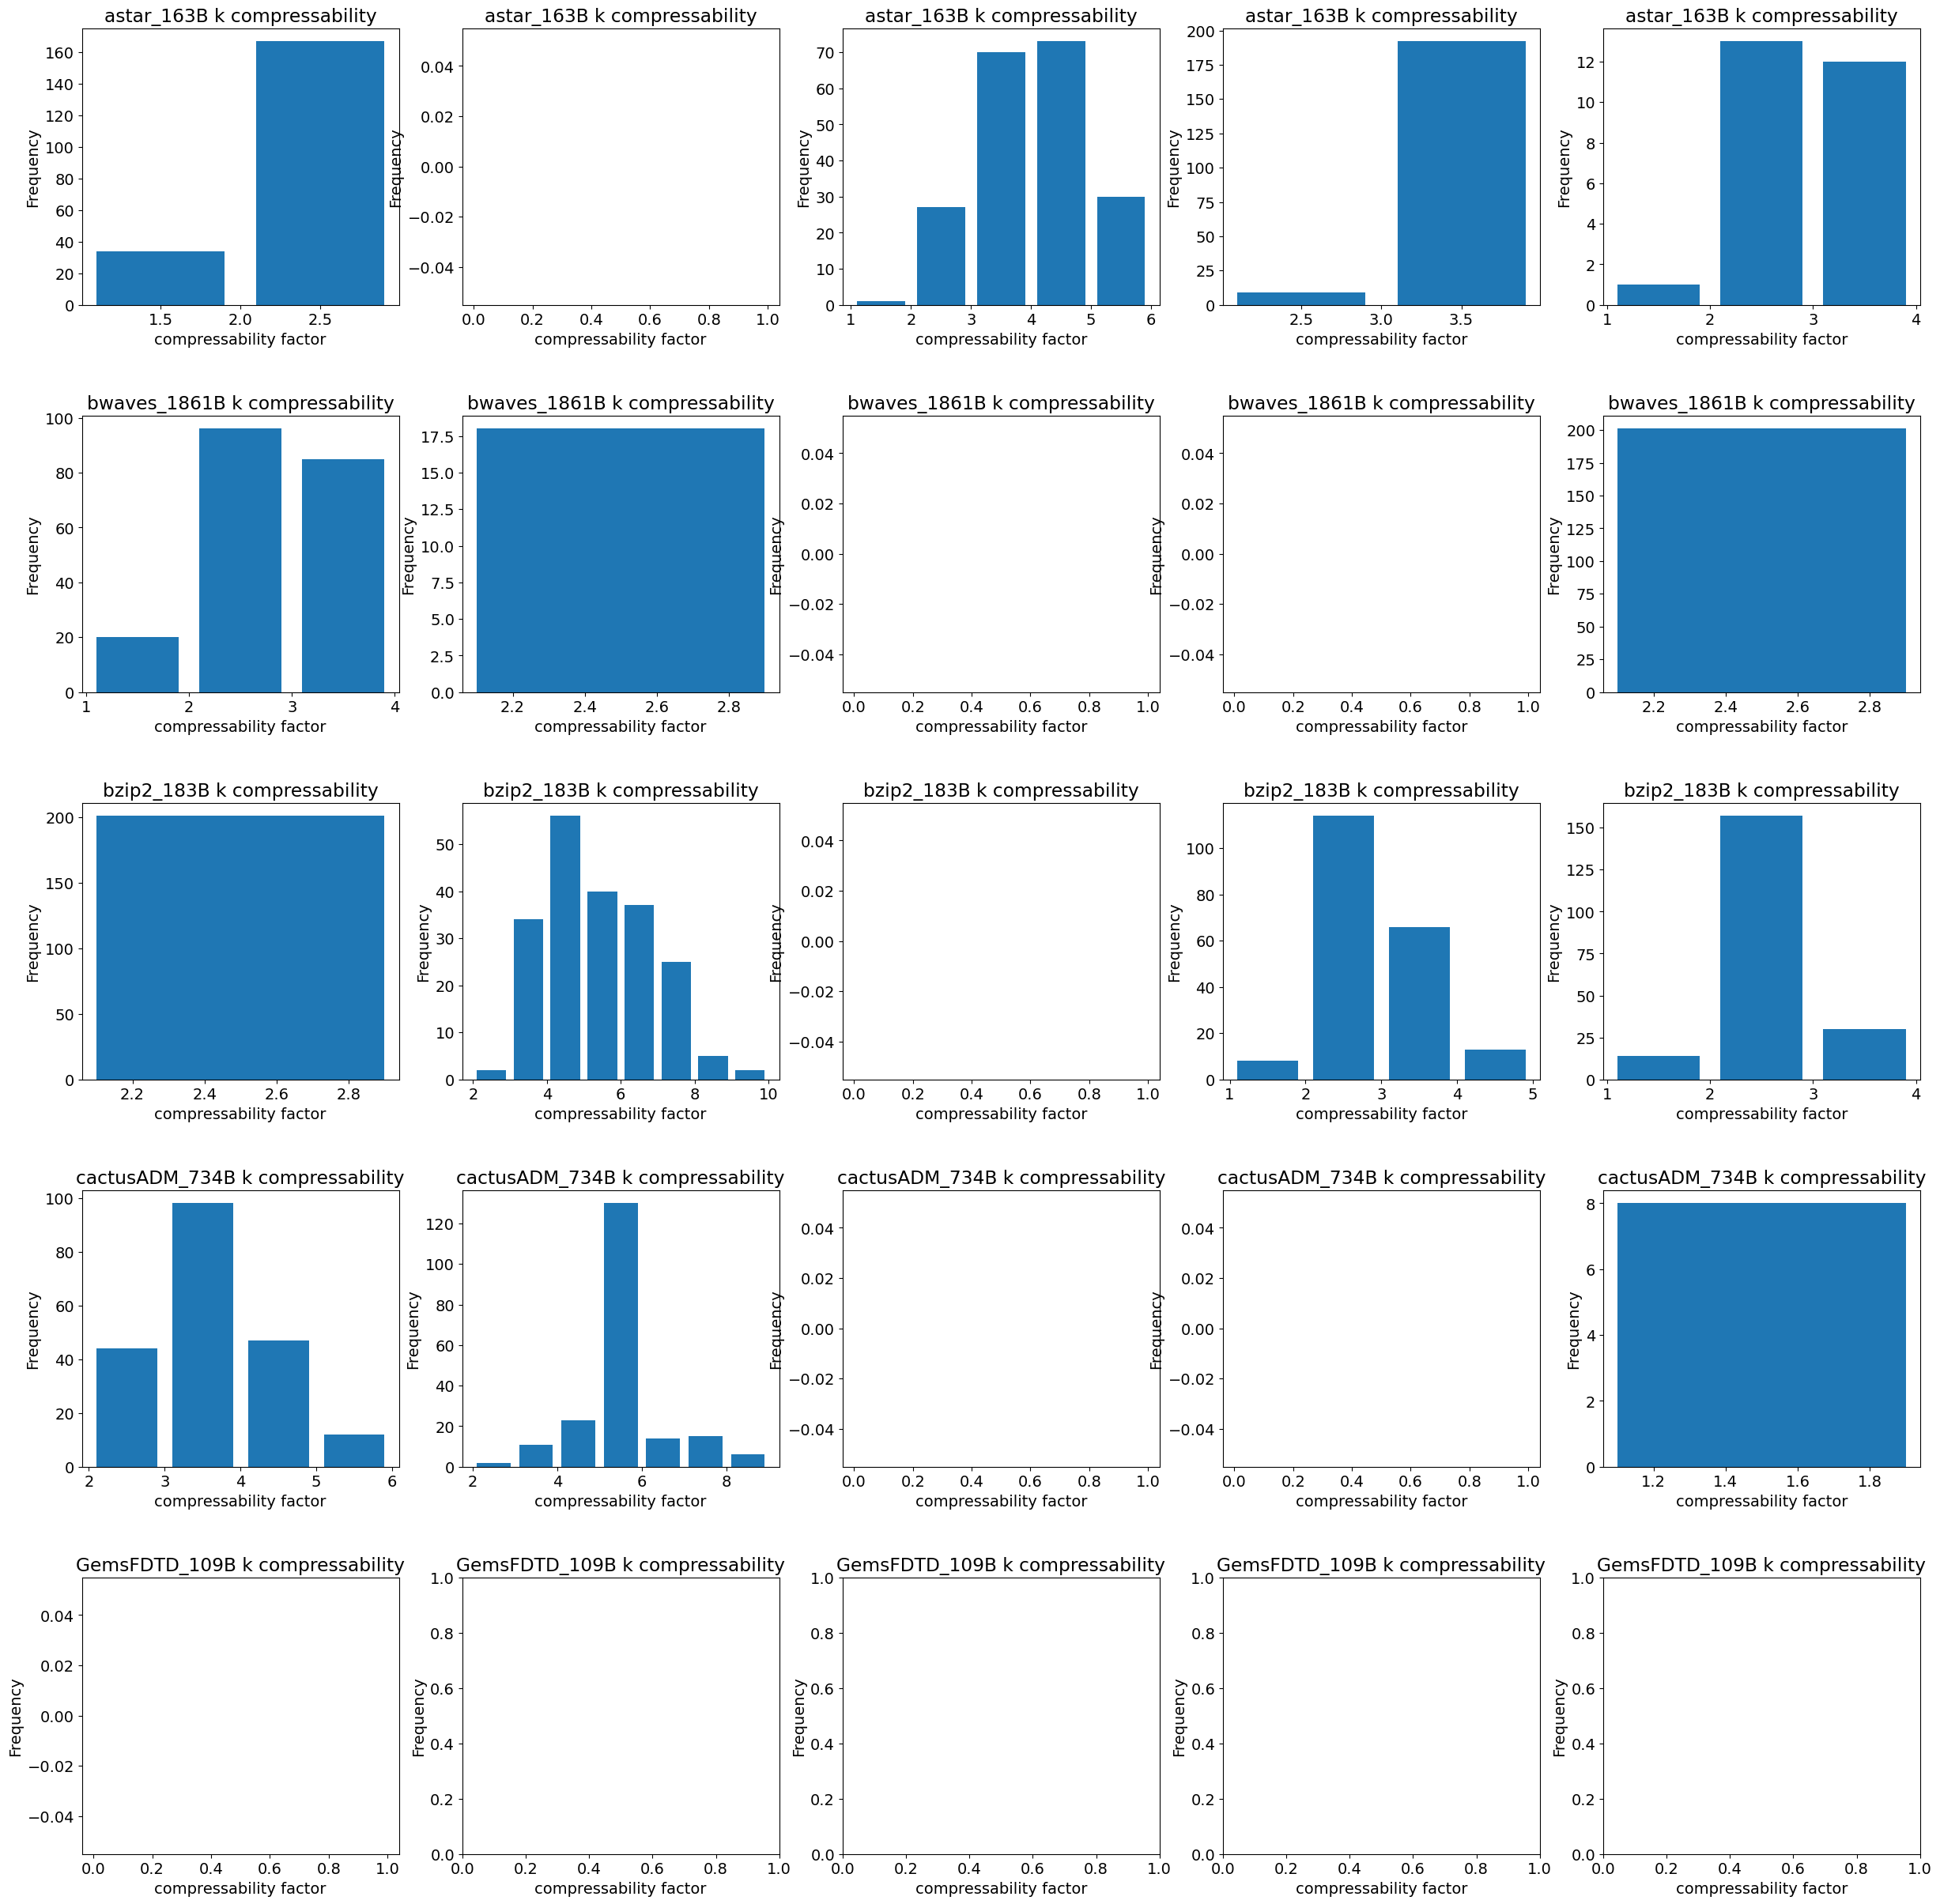

In [7]:
graph_k_compression(experiment_trace_files, traces)
plt.show()

### Percent Unique Values in K Sequences

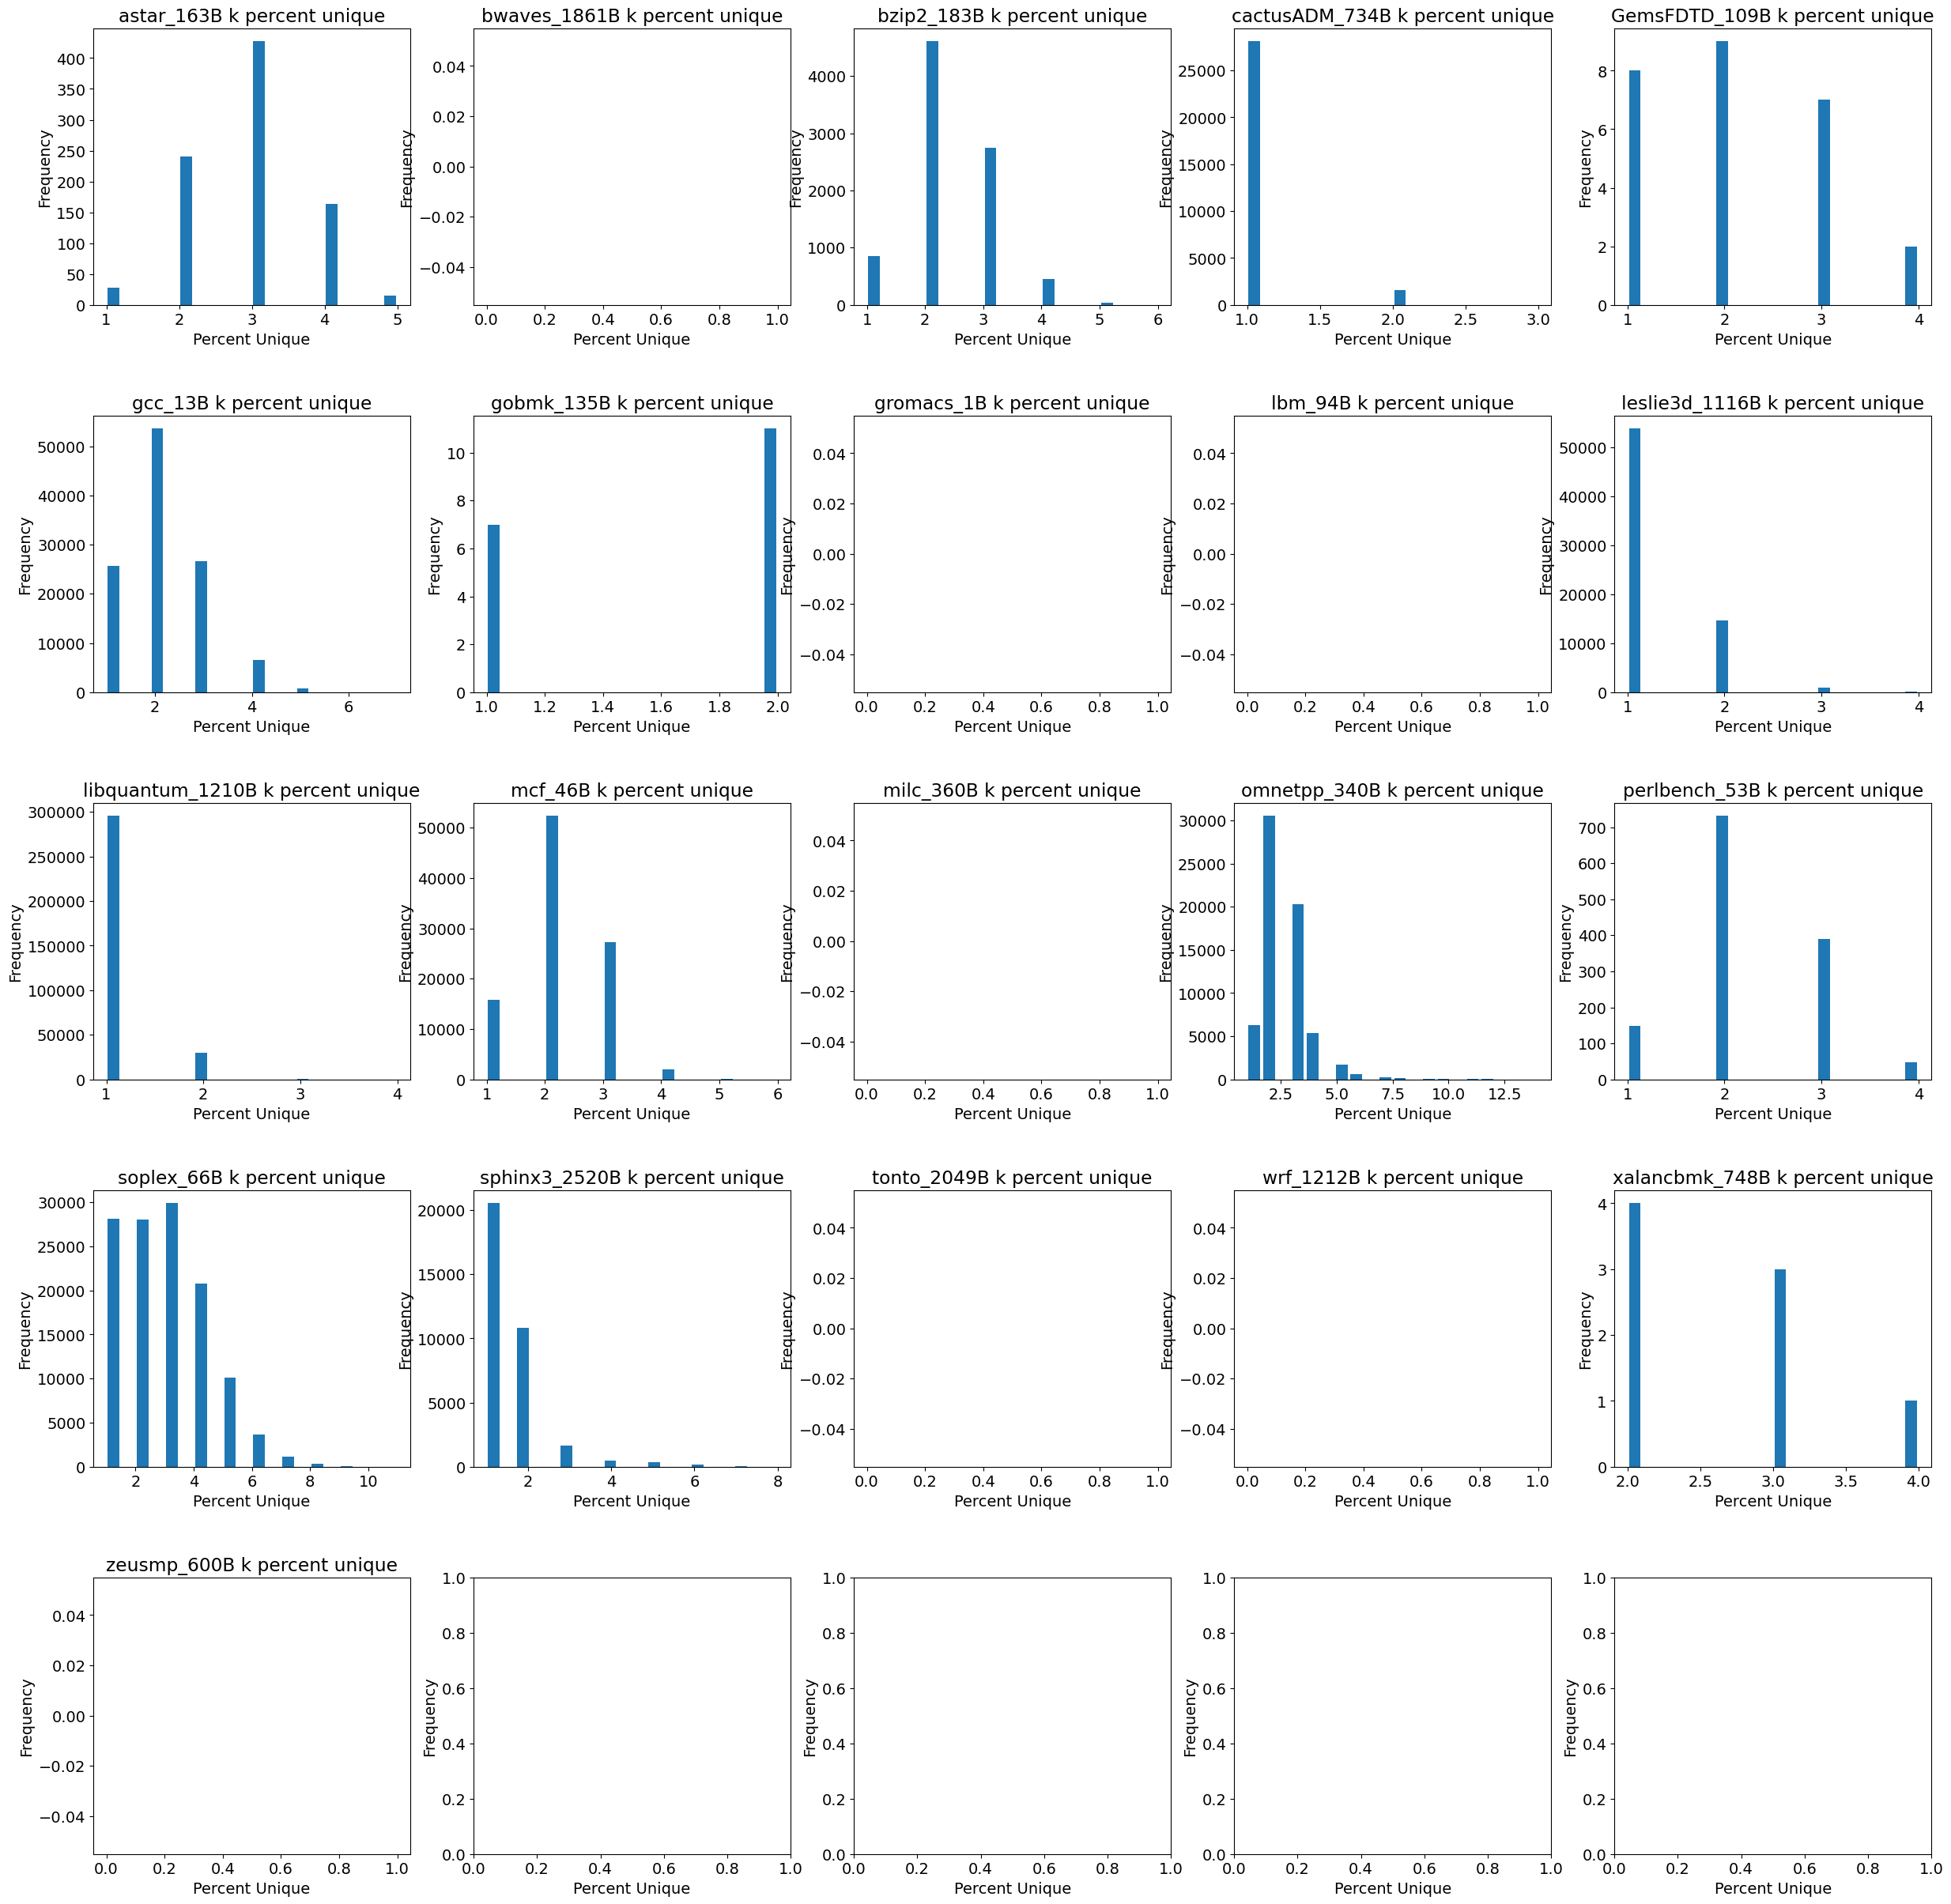

In [8]:
graph_k_unique(experiment_trace_files, traces)
plt.show()

### Harmony with ISB Prefetcher

In [9]:
# Harmony with Best Offset Prefetch Interval Use
# get experiment trace files
experiment = 'experiment_tracer_hawkeye_final_dyn_isb_k_list'
trace_list = open('sim_list/traces.txt', 'r')
experiment_trace_files = []
traces = []

for trace in trace_list:
    trace = trace[:-1]
    traces.append(trace)
    experiment_trace = '../current_output/'+experiment+'/'+trace+'.txt'
    experiment_trace_files.append(experiment_trace)

### K Distribution Graph

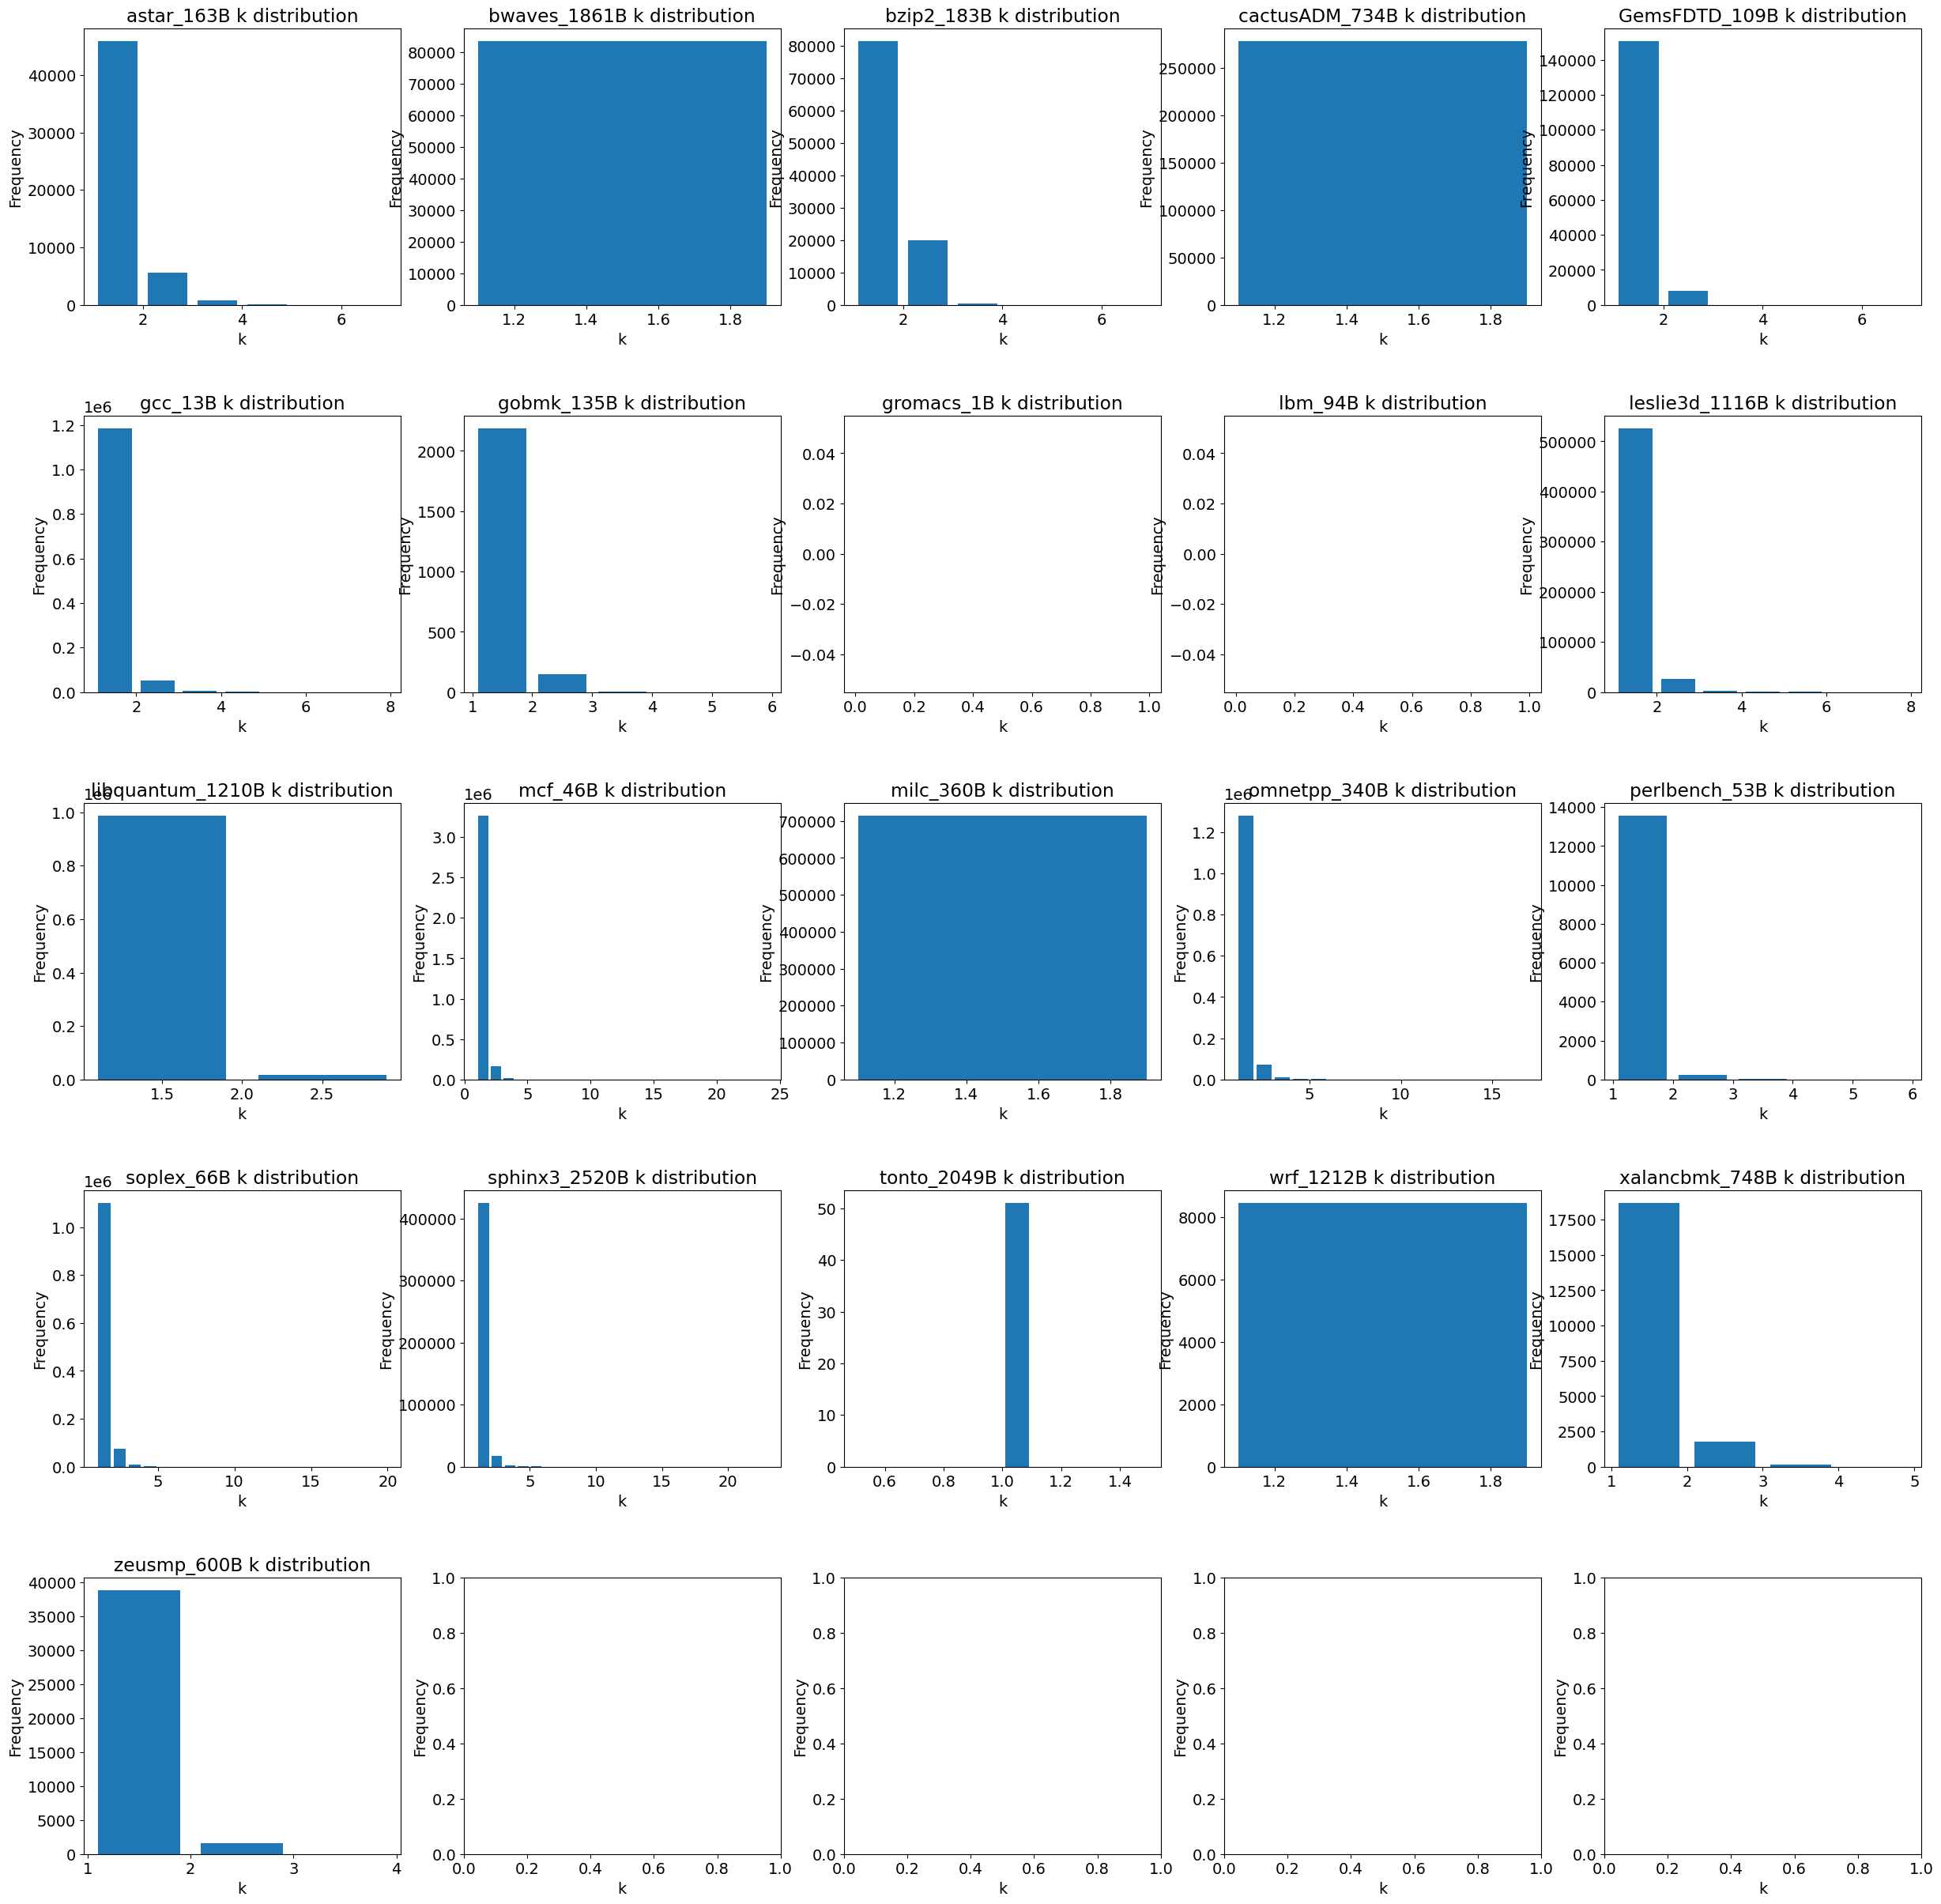

In [10]:
graph_k_distr(experiment_trace_files, traces)
plt.show()

### K Compressability Graph with Sequiter

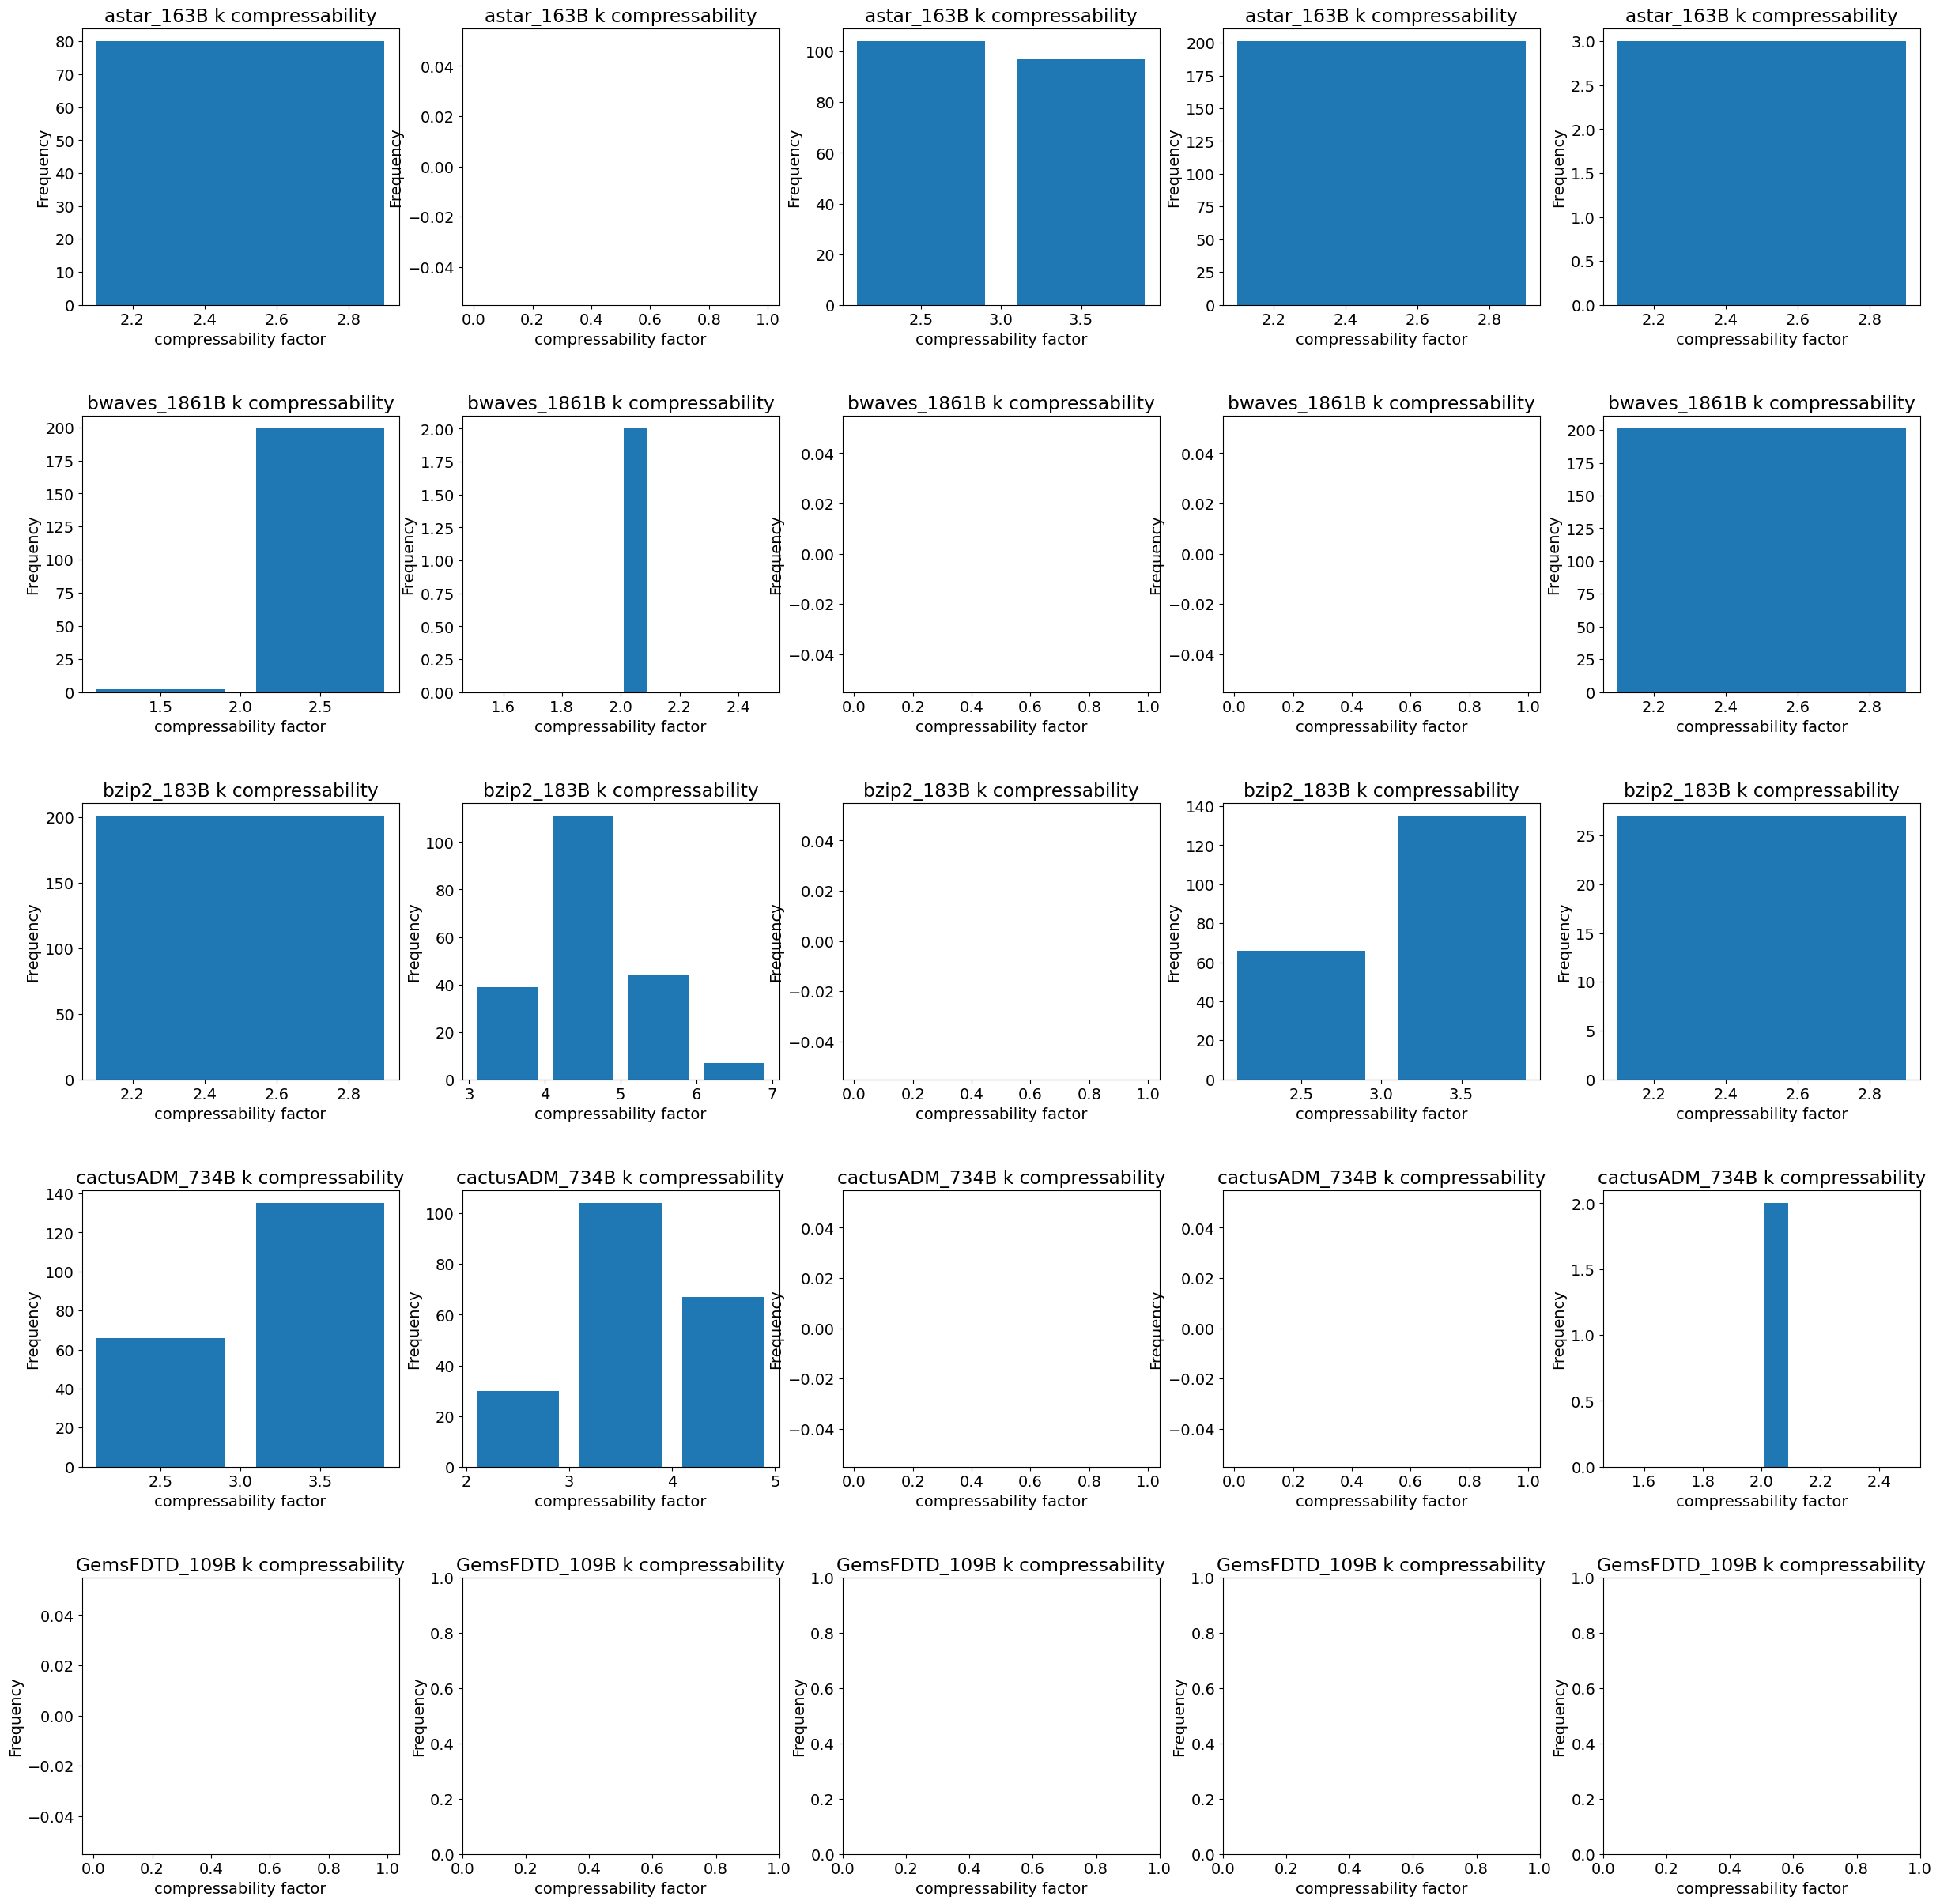

In [11]:
graph_k_compression(experiment_trace_files, traces)
plt.show()

### Percent of Unique values in K sequences Graph

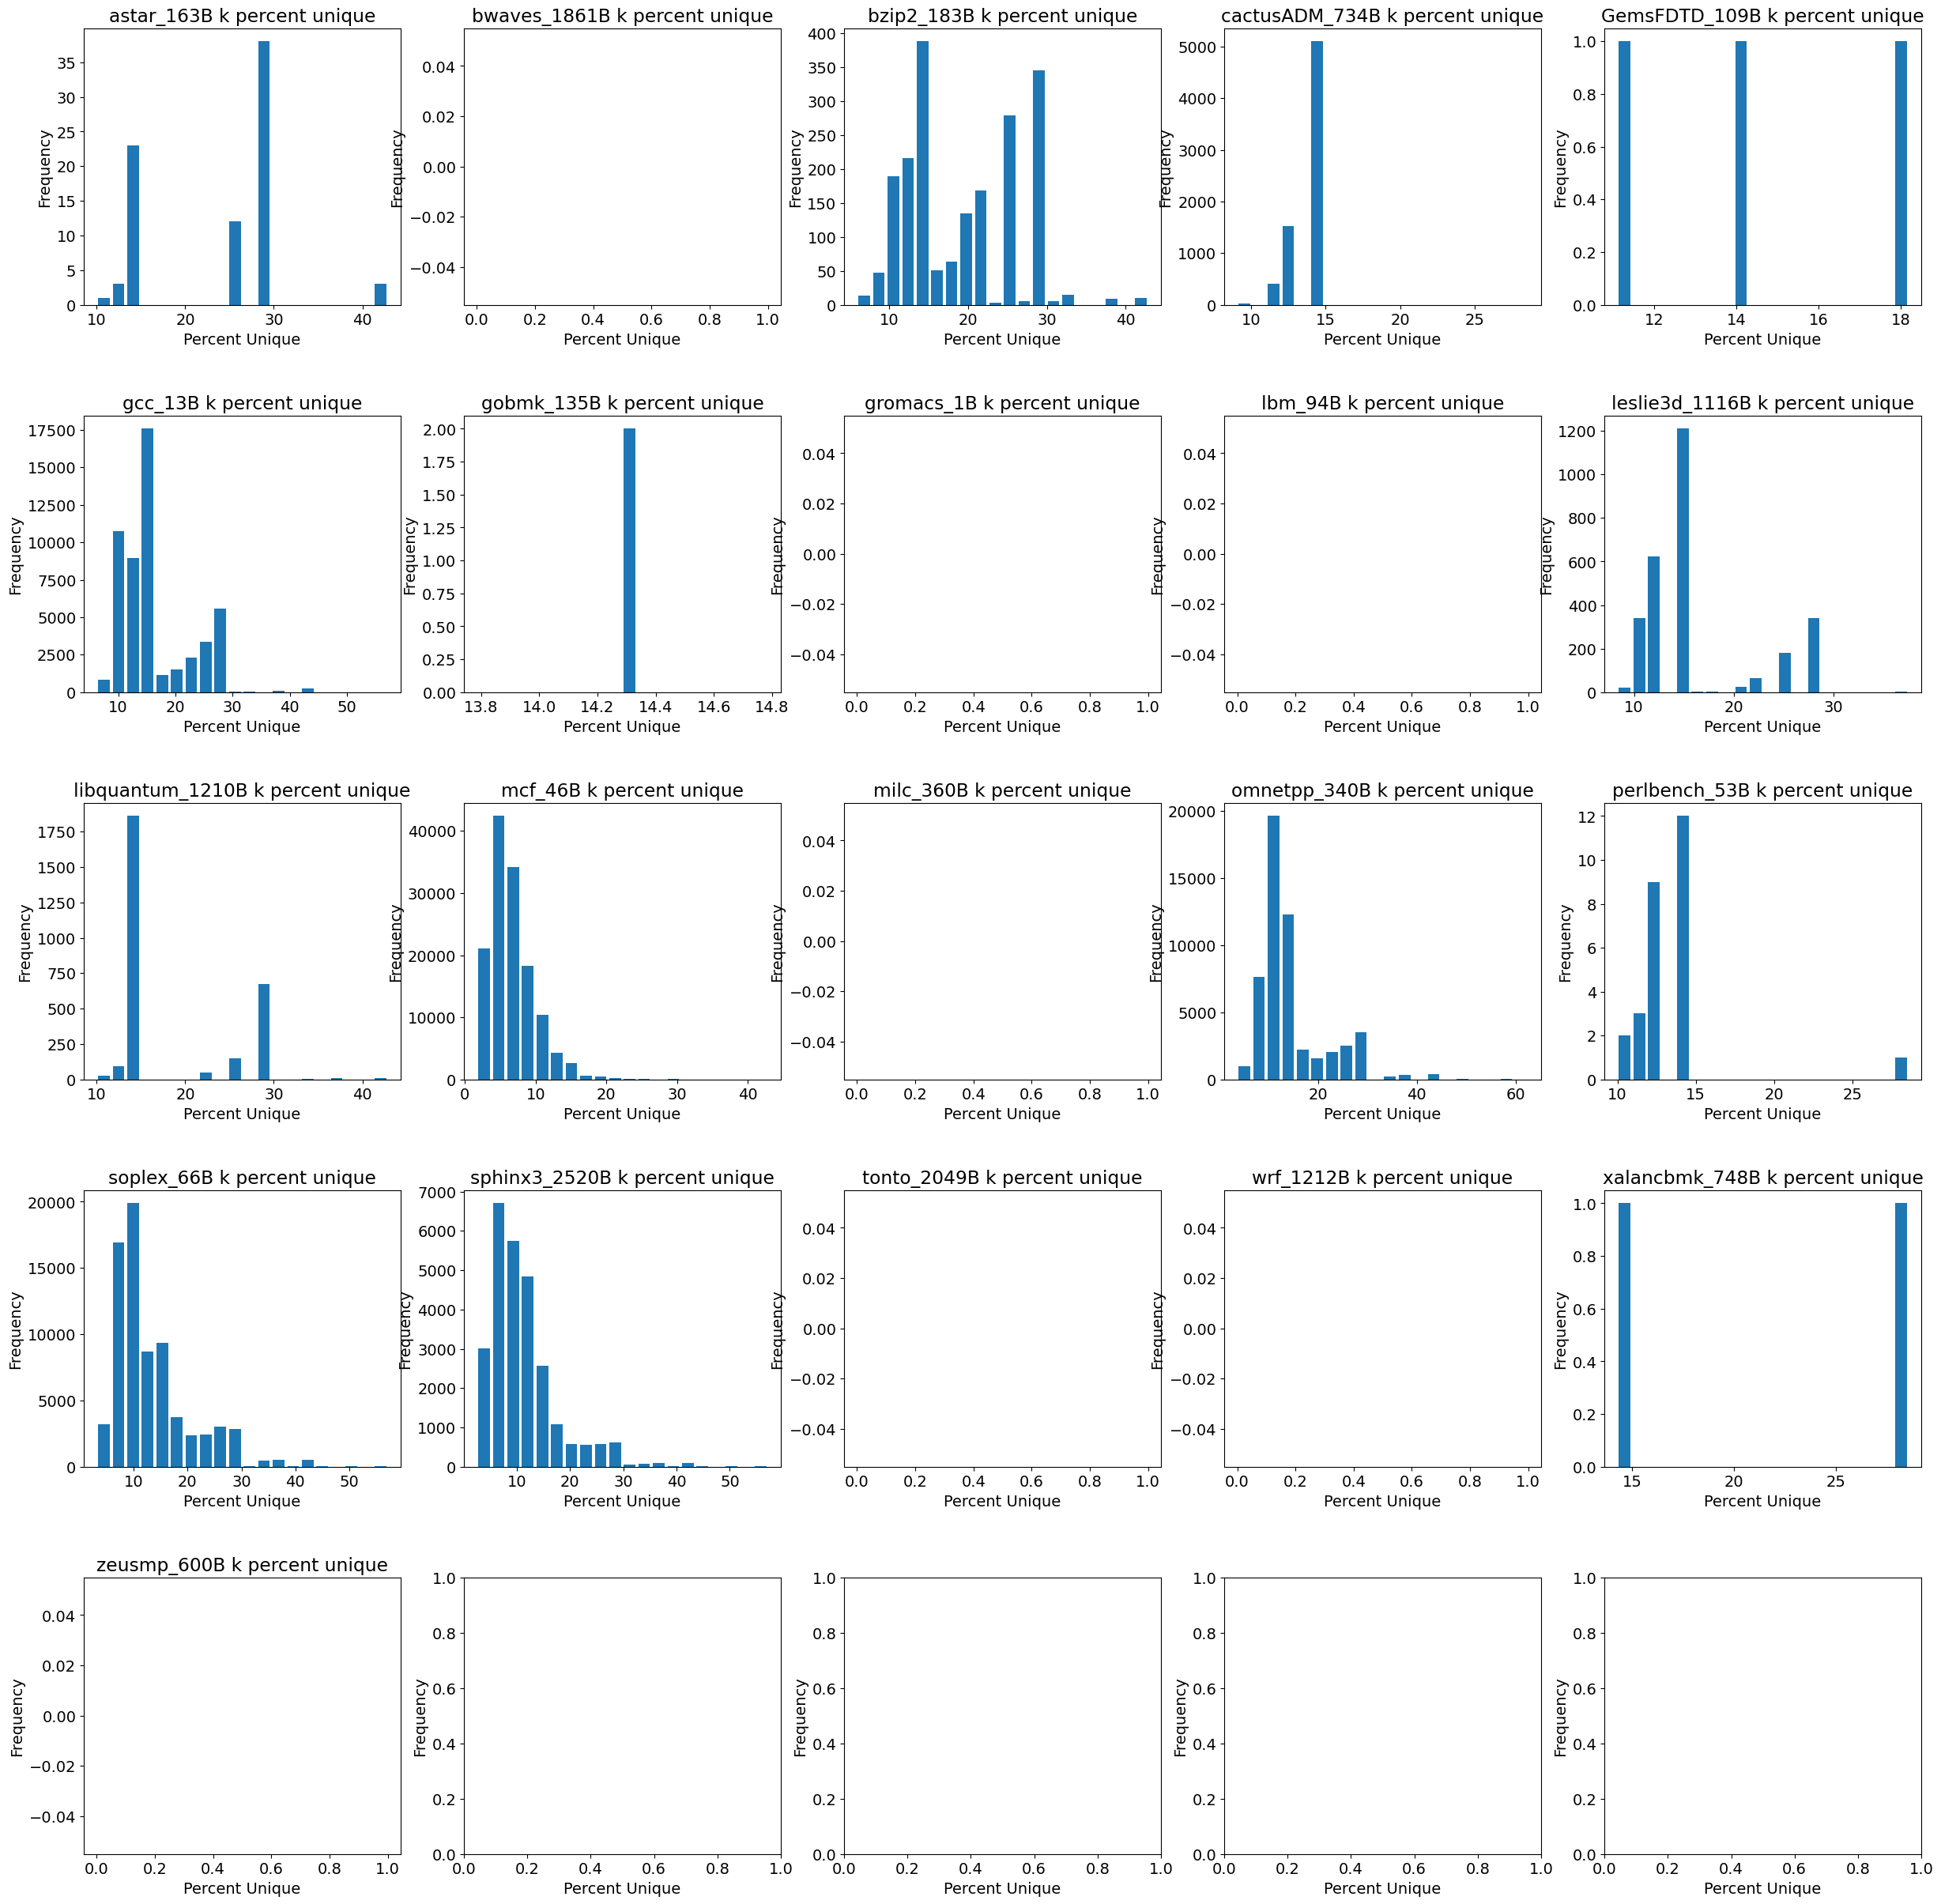

In [12]:
graph_k_percent_unique(experiment_trace_files, traces)
plt.show()

### Analysis

These graphs show that k is dominated by small values between 1 and 5 for the both the Best Offset ISB prefetcher. The compressability graphs show that some sequences of k may be highly predictable, since most benchmarks show compressability factors of 2 or greater. The uniqueness graphs show that for benchmarks with sequences of k longer than 7 values, there is a relatively high proportion of repeated k values, since the percent unique distributions are skewed right.